# Learning Experiment

In [29]:
from draco.learn import linear
from draco.learn import data_util
from draco.run import run
from draco.spec import Task, Query, AspTask
from draco.learn.helper import count_violations
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import logging
from vega3 import VegaLite

logging.basicConfig()
logging.getLogger().setLevel(logging.WARN)

In [2]:
data, _ = data_util.load_data(test_size=0)
data = data[data.source != 'manual']

raw_data = data_util.load_neg_pos_specs()

data_yh = data[data.source == 'younghoon'] 
data_bh = data[data.source == 'bahador']

X = data.negative - data.positive
X_yh = data_yh.negative - data_yh.positive
X_bh = data_bh.negative - data_bh.positive

In [3]:
len(data_yh), len(X_yh), len(X_bh), len(data_bh)

(1152, 1152, 10, 10)

In [4]:
X_yh_train, X_yh_test = train_test_split(X_yh, test_size=0.3)
X_bh_train, X_bh_test = train_test_split(X_bh, test_size=0.3)

In [5]:
clf = linear.train_model(pd.concat([X_yh_train, X_bh]), test_size=0.3)
print()
print(clf.score(X, np.ones(len(X))))
print(clf.score(X_yh_test, np.ones(len(X_yh_test))))
print(clf.score(X_bh, np.ones(len(X_bh))))

Train score:  0.9439579684763573
Dev score:  0.9102040816326531

0.9268502581755593
0.9104046242774566
1.0


In [6]:
clf = linear.train_model(X_bh, test_size=0)

clf.score(X_bh, np.ones(len(X_bh)))

Train score:  1.0


1.0

In [7]:
clf = linear.train_model(X_yh_train, test_size=0.3)

clf.score(X_yh_test, np.ones(len(X_yh_test)))

Train score:  0.9379432624113475
Dev score:  0.9132231404958677


0.9219653179190751

# Apply a learned model to partial specifications

See whether it comes up with the optimum

In [8]:
clf = linear.train_model(X, test_size=0)

Train score:  0.9320137693631669


In [12]:
weights = clf.coef_[0]
names = X.columns

const_dict = dict(zip(map(lambda x: f'{x}_weight', names), map(int, weights*10000)))

In [23]:
task = AspTask('''
% only three encodings
3 { encoding(E): encoding(E) } 3.

% two quantitative, one nominal
2 { type(E,quantitative): encoding(E) } 2.
1 { type(E,nominal): encoding(E) } 1.
:- type(_,ordinal).

% only scatterplots
:- not mark(point).

% always use zero for quantitative
:- type(E,quantitative), not zero(E).

% no aggregations
:- aggregate(E,_).

% no binning
:- bin(E,_).

% ====== Data definitions ======
data_size(30).

fieldtype(n,string).
cardinality(n,10).
interesting(n).

fieldtype(q1,number).
cardinality(q1,30).
interesting(q1).
entropy(q1,38).

fieldtype(q2,number).
cardinality(q2,30).
entropy(q2,39).

% ====== Query constraints ======

task(summary).

mark(point).

encoding(enc_n).
type(enc_n,nominal).
field(enc_n,n).

encoding(enc_q1).
type(enc_q1,quantitative).
field(enc_q1,q1).

encoding(enc_q2).
type(enc_q2,quantitative).
field(enc_q2,q2).
''')

out = run(task,
    constants=const_dict,
    files=['define.lp', 'generate.lp', 'test.lp', 'features.lp', 'weights.lp',
           'assign_weights.lp', 'optimize.lp', 'output.lp']
   )

In [28]:
spec = out.to_vegalite()
spec

{'$schema': 'https://vega.github.io/schema/vega-lite/v2.0.json',
 'data': {'url': '__none__'},
 'encoding': {'color': {'field': 'q2',
   'scale': {'zero': True},
   'type': 'quantitative'},
  'size': {'field': 'q1', 'scale': {'zero': True}, 'type': 'quantitative'},
  'y': {'field': 'n', 'type': 'nominal'}},
 'mark': 'point'}

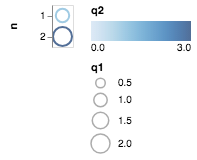

In [31]:
spec['data'] = {'values': [{'q1': 1, 'q2': 1, 'n': 1}, {'q1': 2, 'q2': 3, 'n': 2}]}

VegaLite(spec)